In [ ]:
# Adım 1: Gerekli kütüphaneleri yükleyelim
!pip install torch torchvision torchaudio --quiet
!pip install numpy matplotlib scikit-learn tqdm pandas albumentations --quiet

import torch
import os

# GPU'nun kullanılabilir olup olmadığını kontrol et ve cihazı ayarla
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılacak Cihaz: {device}")

# GPU kullanılıyorsa, adını yazdıralım
if torch.cuda.is_available():
    print(f"GPU Adı: {torch.cuda.get_device_name(0)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.1 MB/s eta 0:00:00
Kullanılacak Cihaz: cuda
GPU Adı: Tesla T4


In [ ]:
# Adım 2.1: Google Drive hesabını Colab ortamına bağlayalım

from google.colab import drive
drive.mount('/content/drive')

# Bağlantının başarılı olduğunu kontrol etmek için Drive'daki dosyaları listeleyelim
# Çıktıda "My Drive" klasörünü görmelisin.
!ls /content/drive/

Mounted at /content/drive
MyDrive


In [ ]:
# Adım 2.2: Google Drive'daki veri setinin yolunu tanımlayalım

# !!! DİKKAT: Bu satırı kendi Drive'ındaki dosya yoluna göre düzenlemelisin!
# Örneğin: drive/My Drive/Proje_Klasorlerim/Weeds-Dataset/weed_augmented
DATASET_DRIVE_PATH = "/content/drive/MyDrive/prostatemobilenet/dataset/denemedataset/patchesstduo3"

# Tanımlanan yolun doğru olup olmadığını ve içinde 'images'/'masks' klasörleri olup olmadığını kontrol edelim
print(f"Tanımlanan veri seti yolu: {DATASET_DRIVE_PATH}")
print("Klasör içeriği:")
!ls -l {DATASET_DRIVE_PATH}

Tanımlanan veri seti yolu: /content/drive/MyDrive/prostatemobilenet/dataset/denemedataset/patchesstduo3
Klasör içeriği:
total 8
drwx------ 2 root root 4096 Jul  3 19:08 images
drwx------ 2 root root 4096 Jul  3 19:08 masks


In [ ]:
# Adım 3: Proje için temel ayarları ve hiperparametreleri tanımlayalım

import random
import numpy as np
import os
import time

# Tekrarlanabilirlik için seed'leri ayarlayalım
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
seeding(SEED)

# Ayarlar
# ---- Drive'daki veri setinin yolunu burada da tanımlayalım ----
DATA_PATH = "/content/drive/MyDrive/prostatemobilenet/dataset/denemedataset/patchesstduo3"

IMAGE_W = 224 # Bu değişken burada tanımlı
IMAGE_H = 224 # Bu değişken burada tanımlıBATCH_SIZE = 32
EPOCHS = 25
LR = 1e-4

COLORMAP = [
    [0, 0, 0],         # 0: Arkaplan veya Benign
    [0, 0, 255],       # 1: Gleason 3 (Mavi)
    [255, 255, 0],     # 2: Gleason 4 (Sarı)
    [255, 0, 0]        # 3: Gleason 5 (Kırmızı)
]

# --- DEĞİŞİKLİK BURADA ---
# Sınıfları prostat kanseri görevine göre güncelliyoruz.
CLASSES = ["Benign", "Gleason_3", "Gleason_4", "Gleason_5"]
NUM_CLASSES = len(CLASSES)
CHECKPOINT_PATH = "gleason_unet_best_model.pth"

In [ ]:
# Adım 4 (DÜZELTİLMİŞ ve GİRİNTİLERİ KONTROL EDİLMİŞ): Segmentasyon için U-Net

import torch
import torch.nn as nn

# --- Global değişkenleri burada da tanımlayalım ---
IMAGE_SIZE = 224
# Adım 3'ten NUM_CLASSES'ı alacağız, şimdilik bir değer verelim
NUM_CLASSES = 4
# ----------------------------------------------------

# Temel Konvolüsyon Bloğu
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

# Encoder Bloğu
class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = ConvBlock(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

# Decoder Bloğu
class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = ConvBlock(out_c + out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

# Orijinal U-Net Mimarisi (Segmentasyon için)
class build_unet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        """ Encoder """
        self.e1 = EncoderBlock(3, 64)
        self.e2 = EncoderBlock(64, 128)
        self.e3 = EncoderBlock(128, 256)
        self.e4 = EncoderBlock(256, 512)

        """ Bottleneck """
        self.b = ConvBlock(512, 1024)

        """ Decoder """
        self.d1 = DecoderBlock(1024, 512)
        self.d2 = DecoderBlock(512, 256)
        self.d3 = DecoderBlock(256, 128)
        self.d4 = DecoderBlock(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, num_classes, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

In [ ]:
# Adım 5 (DÜZELTİLMİŞ): COLORMAP Değişkeni Eklendi

import glob
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- HATA ÇÖZÜMÜ: Gerekli tüm global değişkenleri bu hücrede de tanımla ---
IMAGE_W = 224
IMAGE_H = 224
# Prostat kanseri görevine uygun renk haritası
COLORMAP = [
    [0, 0, 0],         # 0: Arkaplan veya Benign
    [0, 0, 255],       # 1: Gleason 3 (Mavi)
    [255, 255, 0],     # 2: Gleason 4 (Sarı)
    [255, 0, 0]        # 3: Gleason 5 (Kırmızı)
]
# --------------------------------------------------------------------------

# 1. Görüntü ve maske yollarını bulalım ve eşleştirelim
# DATA_PATH Adım 3'te tanımlandığı için burada tekrar tanımlamaya gerek yok,
# Colab bu değişkeni bir önceki hücreden alacaktır.
all_image_paths = sorted(glob.glob(os.path.join(DATA_PATH, "images", "*.png")))
print(f"Toplam bulunan .png görüntü sayısı: {len(all_image_paths)}")

image_paths = []
mask_paths = []
for img_path in all_image_paths:
    img_filename = os.path.basename(img_path)
    mask_path = os.path.join(DATA_PATH, "masks", img_filename)
    if os.path.exists(mask_path):
        image_paths.append(img_path)
        mask_paths.append(mask_path)
print(f"Eşleştirilen görüntü-maske çifti sayısı: {len(image_paths)}")

# ... (kodun geri kalanı tamamen aynı) ...

# 2. Veriyi eğitim, doğrulama ve test setlerine bölelim
train_x, temp_x, train_y, temp_y = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=SEED
)
valid_x, test_x, valid_y, test_y = train_test_split(
    temp_x, temp_y, test_size=0.5, random_state=SEED
)

# 3. Görüntü zenginleştirme (Data Augmentation)
train_transform = A.Compose([
    A.Resize(IMAGE_H, IMAGE_W),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.ColorJitter(p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# 4. Özel Dataset Sınıfımız (Segmentasyon için)
class SegmentationDataset(Dataset):
    def __init__(self, images_path, masks_path, colormap, size, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.colormap = colormap
        self.size = size
        self.transform = transform
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
        else:
            resizer = A.Compose([A.Resize(self.size[0], self.size[1])])
            resized = resizer(image=image, mask=mask)
            image = resized['image']
            mask = resized['mask']

            normalizer = A.Compose([
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
            image = normalizer(image=image)['image']

        mask_class = np.zeros((self.size[0], self.size[1]), dtype=np.int64)
        for i, color in enumerate(self.colormap):
            indices = np.all(mask == color, axis=-1)
            mask_class[indices] = i

        mask_class = torch.from_numpy(mask_class).long()

        return image, mask_class

    def __len__(self):
        return self.n_samples

# 5. DataLoader'ları oluşturalım
train_dataset = SegmentationDataset(train_x, train_y, COLORMAP, (IMAGE_H, IMAGE_W), transform=train_transform)
valid_dataset = SegmentationDataset(valid_x, valid_y, COLORMAP, (IMAGE_H, IMAGE_W), transform=None)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Eğitim seti boyutu: {len(train_dataset)}")
print(f"Doğrulama seti boyutu: {len(valid_dataset)}")
print(f"Test seti boyutu: {len(test_x)}")

Toplam bulunan .png görüntü sayısı: 6743
Eşleştirilen görüntü-maske çifti sayısı: 6743
Eğitim seti boyutu: 5394
Doğrulama seti boyutu: 674
Test seti boyutu: 675


In [ ]:
# Adım 6 (DÜZELTİLMİŞ): Eğitim Döngüsü ve Gerekli Sınıflar Bir Arada

import time
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# --- HATA ÇÖZÜMÜ: Gerekli Sınıfları Doğrudan Bu Hücreye TAnımla ---

class DiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2).float()

        # Ignore_index'i (arkaplanı) hesaptan çıkarabiliriz
        # Bu, modelin sadece otları öğrenmeye odaklanmasını sağlar ve performansı artırabilir.
        if self.num_classes > 1:
            targets_one_hot = targets_one_hot[:, 1:, :, :] # Arkaplan sınıfını (indeks 0) atla
            probs = probs[:, 1:, :, :]

        intersection = torch.sum(probs * targets_one_hot, dim=(0, 2, 3))
        union = torch.sum(probs, dim=(0, 2, 3)) + torch.sum(targets_one_hot, dim=(0, 2, 3))

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1.0 - dice.mean()

class DiceCELoss(nn.Module):
    def __init__(self, num_classes, dice_weight=0.6, ce_weight=0.4):
        super(DiceCELoss, self).__init__()
        self.dice_loss = DiceLoss(num_classes)
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight

    def forward(self, logits, targets):
        dice_loss_val = self.dice_loss(logits, targets)
        ce_loss_val = self.ce_loss(logits, targets)
        return self.dice_weight * dice_loss_val + self.ce_weight * ce_loss_val

# -------------------------------------------------------------------------


# --- Modeli, kayıp fonksiyonunu ve optimizer'ı hazırla ---
model = build_unet(num_classes=NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True, factor=0.1)
loss_fn = DiceCELoss(num_classes=NUM_CLASSES)

best_valid_loss = float('inf')

history = {
    "train_loss": [],
    "valid_loss": []
}

# --- Eğitim Başlıyor ---
for epoch in range(EPOCHS):
    start_time = time.time()

    # --- Eğitim Aşaması ---
    model.train()
    epoch_train_loss = 0.0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Eğitim]"):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    # --- Doğrulama Aşaması ---
    model.eval()
    epoch_valid_loss = 0.0

    with torch.no_grad():
        for x, y in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Doğrulama]"):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            epoch_valid_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_valid_loss = epoch_valid_loss / len(valid_loader)

    history["train_loss"].append(avg_train_loss)
    history["valid_loss"].append(avg_valid_loss)

    scheduler.step(avg_valid_loss)

    end_time = time.time()
    epoch_duration = time.time() - start_time

    print(f"Epoch {epoch+1:02}/{EPOCHS} | Süre: {epoch_duration:.2f}s")
    print(f"\tEğitim   Loss: {avg_train_loss:.4f}")
    print(f"\tDoğrulama Loss: {avg_valid_loss:.4f}")

    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        print(f"\t==> En iyi model kaydedildi: {CHECKPOINT_PATH}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/25 [Doğrulama]: 100%|██████████| 22/22 [07:17<00:00, 19.89s/it]


Epoch 01/25 | Süre: 3906.22s
	Eğitim   Loss: 0.8974
	Doğrulama Loss: 0.8175
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 2/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.08it/s]


Epoch 02/25 | Süre: 236.78s
	Eğitim   Loss: 0.7638
	Doğrulama Loss: 0.7275
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 3/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.06it/s]


Epoch 03/25 | Süre: 228.60s
	Eğitim   Loss: 0.7008
	Doğrulama Loss: 0.6783
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 4/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.06it/s]


Epoch 04/25 | Süre: 228.81s
	Eğitim   Loss: 0.6641
	Doğrulama Loss: 0.6513
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 5/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.07it/s]


Epoch 05/25 | Süre: 228.59s
	Eğitim   Loss: 0.6426
	Doğrulama Loss: 0.6350
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 6/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.06it/s]


Epoch 06/25 | Süre: 228.52s
	Eğitim   Loss: 0.6300
	Doğrulama Loss: 0.6252
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 7/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.07it/s]


Epoch 07/25 | Süre: 228.52s
	Eğitim   Loss: 0.6221
	Doğrulama Loss: 0.6190
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 8/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.05it/s]


Epoch 08/25 | Süre: 228.57s
	Eğitim   Loss: 0.6168
	Doğrulama Loss: 0.6145
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 9/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.07it/s]


Epoch 09/25 | Süre: 228.49s
	Eğitim   Loss: 0.6131
	Doğrulama Loss: 0.6115
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 10/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.06it/s]


Epoch 10/25 | Süre: 228.66s
	Eğitim   Loss: 0.6104
	Doğrulama Loss: 0.6092
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 11/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.06it/s]


Epoch 11/25 | Süre: 228.50s
	Eğitim   Loss: 0.6083
	Doğrulama Loss: 0.6073
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 12/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.06it/s]


Epoch 12/25 | Süre: 228.53s
	Eğitim   Loss: 0.6067
	Doğrulama Loss: 0.6061
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 13/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.05it/s]


Epoch 13/25 | Süre: 228.74s
	Eğitim   Loss: 0.6056
	Doğrulama Loss: 0.6050
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 14/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.07it/s]


Epoch 14/25 | Süre: 228.50s
	Eğitim   Loss: 0.6047
	Doğrulama Loss: 0.6042
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 15/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.06it/s]


Epoch 15/25 | Süre: 228.78s
	Eğitim   Loss: 0.6039
	Doğrulama Loss: 0.6035
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 16/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.06it/s]


Epoch 16/25 | Süre: 228.62s
	Eğitim   Loss: 0.6033
	Doğrulama Loss: 0.6031
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 17/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.06it/s]


Epoch 17/25 | Süre: 228.79s
	Eğitim   Loss: 0.6028
	Doğrulama Loss: 0.6026
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 18/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.07it/s]


Epoch 18/25 | Süre: 228.52s
	Eğitim   Loss: 0.6024
	Doğrulama Loss: 0.6022
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 19/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.06it/s]


Epoch 19/25 | Süre: 228.60s
	Eğitim   Loss: 0.6021
	Doğrulama Loss: 0.6019
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 20/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.07it/s]


Epoch 20/25 | Süre: 228.68s
	Eğitim   Loss: 0.6018
	Doğrulama Loss: 0.6017
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 21/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.07it/s]


Epoch 21/25 | Süre: 228.41s
	Eğitim   Loss: 0.6016
	Doğrulama Loss: 0.6014
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 22/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.07it/s]


Epoch 22/25 | Süre: 228.47s
	Eğitim   Loss: 0.6014
	Doğrulama Loss: 0.6013
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 23/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.07it/s]


Epoch 23/25 | Süre: 228.47s
	Eğitim   Loss: 0.6012
	Doğrulama Loss: 0.6011
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 24/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.06it/s]


Epoch 24/25 | Süre: 228.42s
	Eğitim   Loss: 0.6011
	Doğrulama Loss: 0.6010
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


Epoch 25/25 [Doğrulama]: 100%|██████████| 22/22 [00:10<00:00,  2.07it/s]


Epoch 25/25 | Süre: 228.44s
	Eğitim   Loss: 0.6009
	Doğrulama Loss: 0.6009
	==> En iyi model kaydedildi: gleason_unet_best_model.pth


In [ ]:
import shutil

destination_path = "/content/drive/MyDrive/prostatemobilenet/gleason_unet_best_model.pth"
shutil.move(CHECKPOINT_PATH, destination_path)
print(f"Model başarıyla Drive'a taşındı: {destination_path}")

Model başarıyla Drive'a taşındı: /content/drive/MyDrive/prostatemobilenet/gleason_unet_best_model.pth


Test verisi tahmin ediliyor (ilk 100)...


  1%|          | 12/1770 [00:05<13:18,  2.20it/s]



Test Seti Sınıflandırma Raporu (İlk 100 Görüntü - Pixel-Level)
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00   5218304
   Gleason_3       0.00      0.00      0.00         0
   Gleason_4       0.00      0.00      0.00         0
   Gleason_5       0.00      0.00      0.00         0

    accuracy                           1.00   5218304
   macro avg       0.25      0.25      0.25   5218304
weighted avg       1.00      1.00      1.00   5218304

Ortalama IoU: 0.2500


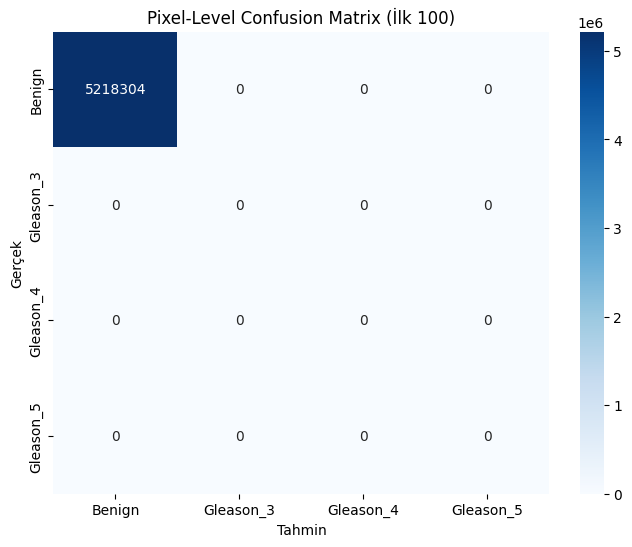

In [20]:
# --- Gerekli Kütüphaneler ---
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn

# --- Cihaz Ayarı ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Parametreler ---
IMAGE_H = 224
IMAGE_W = 224
BATCH_SIZE = 8
CLASSES = ["Benign", "Gleason_3", "Gleason_4", "Gleason_5"]
NUM_CLASSES = len(CLASSES)
COLORMAP = [
    [0, 255, 0],     # Benign
    [0, 0, 255],     # Gleason 3
    [255, 255, 0],   # Gleason 4
    [255, 0, 0]      # Gleason 5
]
LABEL_TO_COLOR = {
    0: [0, 255, 0],
    1: [0, 0, 255],
    2: [255, 255, 0],
    3: [255, 0, 0]
}
CHECKPOINT_PATH = "/content/drive/MyDrive/prostatemobilenet/gleason_unet_best_model.pth"

# --- UNet Model Tanımı ---
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = ConvBlock(in_c, out_c)
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        s = self.conv(x)
        p = self.pool(s)
        return s, p

class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_c + out_c, out_c)
    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.e1 = EncoderBlock(3, 64)
        self.e2 = EncoderBlock(64, 128)
        self.e3 = EncoderBlock(128, 256)
        self.e4 = EncoderBlock(256, 512)
        self.b = ConvBlock(512, 1024)
        self.d1 = DecoderBlock(1024, 512)
        self.d2 = DecoderBlock(512, 256)
        self.d3 = DecoderBlock(256, 128)
        self.d4 = DecoderBlock(128, 64)
        self.outputs = nn.Conv2d(64, num_classes, kernel_size=1)
    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        b = self.b(p4)
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        return self.outputs(d4)

# --- Dataset Sınıfı ---
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, colormap, size, transform=None):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
        self.mask_paths = [os.path.join(mask_dir, 'mask_' + os.path.basename(p)) for p in self.image_paths]
        self.colormap = colormap
        self.size = size
        self.transform = transform

    def __getitem__(self, index):
        image = cv2.imread(self.image_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        label_mask = np.zeros((self.size[0], self.size[1]), dtype=np.int64)
        for idx, color in enumerate(self.colormap):
            label_mask[np.all(mask == color, axis=-1)] = idx
        return image, torch.from_numpy(label_mask).long()

    def __len__(self):
        return len(self.image_paths)

# --- Dönüşüm ---
test_transform = A.Compose([
    A.Resize(IMAGE_H, IMAGE_W),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# --- Dataset ve DataLoader ---
test_dataset = SegmentationDataset(
    image_dir='/content/drive/My Drive/prostatemobilenet/dataset_patches/test_images',
    mask_dir='/content/drive/My Drive/prostatemobilenet/dataset_patches/test_masks',
    colormap=COLORMAP,
    size=(IMAGE_H, IMAGE_W),
    transform=test_transform
)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Modeli Yükle ---
model = build_unet(num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
model.to(device)
model.eval()

# --- Prediction klasörü ---
pred_dir = "/content/drive/MyDrive/pred"
os.makedirs(pred_dir, exist_ok=True)

# --- Tahmin & Kaydet (İlk 100 Görsel) ---
all_preds = []
all_targets = []
processed = 0

print("Test verisi tahmin ediliyor (ilk 100)...")
with torch.no_grad():
    for images, masks in tqdm(test_loader):
        for i in range(images.shape[0]):
            if processed >= 200:
                break

            image = images[i].unsqueeze(0).to(device)
            mask = masks[i].unsqueeze(0).to(device)

            output = model(image)
            pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
            true_mask = mask.squeeze(0).cpu().numpy()

            all_preds.append(pred)
            all_targets.append(true_mask)

            # Renkli çıktı oluştur
            color_pred = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
            for cls_id, color in LABEL_TO_COLOR.items():
                color_pred[pred == cls_id] = color
            save_path = os.path.join(pred_dir, f"pred_{processed:03}.png")
            cv2.imwrite(save_path, cv2.cvtColor(color_pred, cv2.COLOR_RGB2BGR))

            processed += 1
        if processed >= 100:
            break

# --- Değerlendirme ---
all_preds = np.array(all_preds).flatten()
all_targets = np.array(all_targets).flatten()
labels = list(range(NUM_CLASSES))

print("\n" + "="*50)
print("Test Seti Sınıflandırma Raporu (İlk 100 Görüntü - Pixel-Level)")
print("="*50)
print(classification_report(all_targets, all_preds, labels=labels, target_names=CLASSES, zero_division=0))
iou = jaccard_score(all_targets, all_preds, labels=labels, average='macro', zero_division=0)
print(f"Ortalama IoU: {iou:.4f}")
print("="*50)

# --- Confusion Matrix ---
cm = confusion_matrix(all_targets, all_preds, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Pixel-Level Confusion Matrix (İlk 100)")
plt.show()
